In [ ]:
import os, time
#import country_converter as coco

from osgeo import gdal
import pandas as pd 
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path 
#import pycountry 

import rasterio as rs
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.plot import plotting_extent
from rasterio.merge import merge
import rasterio.mask
from rasterio import shutil as rio_shutil
#from rasterio.vrt import WarpedVRT
import re

import glob 
def tPrint(s):
    print("%s\t%s" % (time.strftime("%H:%M:%S"), s))

In [39]:
## Taken from the code provided by Jun and Melda thankyoouuuu

def crop_to_shp(path_name, df, filePrefix):
    raster = rs.open(path_name)
    # Mask to shapefile
    out_array, out_trans = rs.mask.mask(dataset=raster, shapes=df.geometry, crop=True)

    out_meta = raster.meta.copy()
    out_meta.update({"height": out_array.shape[1], 
                      "width": out_array.shape[2],
                      "transform": out_trans})
    return out_array, out_meta


def export_raster_to_geotiff(array, meta, path, fileName, filePrefix):
    Cropped_outputfile = path + fileName
    with rs.open(Cropped_outputfile, 'w', **meta, compress = 'LZW', tiled=True) as dest:
        dest.write(array)
    return Cropped_outputfile
    tPrint(f"{countryCode}_{adm1Index} - {filePrefix} exported")

def open_files_in_list(fileList):
    outputList = []
    for fp in fileList:
        src = rs.open(fp)
        outputList.append(src) 
    return outputList

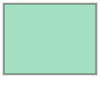

In [5]:
city = gpd.read_file("../data/Kumasi_shp/clipping_boundary.geojson").set_crs(epsg=4326)
bound = city.geometry.iloc[0]
bound.buffer(0)

In [41]:
## pluvial 
os.chdir("/Users/ccsuehara/GH_folders/ghana_access/data/Ghana/pluvial")
pluv = glob.glob("*.tif")
## fluvial
os.chdir("/Users/ccsuehara/GH_folders/ghana_access/data/Ghana/fluvial_undefended")
fluv = glob.glob("*.tif")

os.chdir("/Users/ccsuehara/GH_folders/ghana_access/scripts")


for each in pluv:
    out_arr, out_meta = crop_to_shp("../data/Ghana/pluvial/" + each, city, "plu")
    export_raster_to_geotiff(out_arr, out_meta, "../data/processed/Kumasi/", each,"plu")

for each in fluv:
    out_arr, out_meta = crop_to_shp("../data/Ghana/fluvial_undefended/" + each, city, "flu")
    export_raster_to_geotiff(out_arr, out_meta, "../data/processed/Kumasi/", each,"plu")

dic_files = {'ev_5': glob.glob("../data/processed/Kumasi/*_1in5.tif"),
             'ev_10': glob.glob("../data/processed/Kumasi/*_1in10.tif"),
            'ev_20': glob.glob("../data/processed/Kumasi/*_1in20.tif"),
            'ev_50': glob.glob("../data/processed/Kumasi/*_1in50.tif"),
            'ev_75': glob.glob("../data/processed/Kumasi/*_1in75.tif"),
            'ev_100': glob.glob("../data/processed/Kumasi/*_1in100.tif"),
            'ev_200': glob.glob("../data/processed/Kumasi/*_1in200.tif"),
            'ev_250': glob.glob("../data/processed/Kumasi/*_1in250.tif"),
            'ev_500': glob.glob("../data/processed/Kumasi/*_1in500.tif"),
            'ev_1000': glob.glob("../data/processed/Kumasi/*_1in1000.tif")}

for key, val in dic_files.items():
    out_lst = open_files_in_list(val)
    floodArray, out_trans = merge(out_lst, method='max')
    out_meta = out_lst[0].meta.copy()
    out_meta.update({"height": floodArray.shape[1], 
                            "width": floodArray.shape[2],
                            "transform": out_trans})
    with rs.open("../data/processed/Kumasi/merged/" + key + ".tif", 'w', **out_meta, compress = 'LZW', tiled=True) as dest:
          dest.write(floodArray)